In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import nan
import math
import numpy as np
import pandas as pd
import csv
import pdb
import os
import matplotlib.pyplot as plt
import timeit
import feda # feda.py must be in same directory

In [2]:
def load_data(directory, target_var):
    full_data = []
    if directory[-1] != '/':
        directory = directory + '/'
    for root,dir,files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                filepath = directory + file
                print('Loading: ', file)
                csv_data = np.genfromtxt(filepath, delimiter=',')
                csv_data = np.delete(csv_data, 0, 0)
                full_data.append(csv_data)
    try:
        features = np.vstack(full_data)
        ground_truth = features[:,target_var]
        features = np.delete(features, target_var, axis=1)
    except:
        print("Loading Error: Data not found")
    return features, ground_truth, full_data
    

In [3]:
def load_data_cv(directory, target_var):
    print("Loading data")
    full_data = []
    file_names = []
    ground_truth = []
    features = []
    if directory[-1] != '/':
        directory = directory + '/'
    for root,dir,files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                filepath = directory + file
                print('Loading: ', file)
                csv_data = np.genfromtxt(filepath, delimiter=',')
                csv_data = np.delete(csv_data, 0, 0)
                full_data.append(csv_data)
                file_names.append(file)
    for file in range(0,len(full_data)):
        ground_truth.append(full_data[file][:,target_var])
        features.append(np.delete(full_data[file], target_var, axis=1))
        
    return features, ground_truth, full_data, file_names

In [4]:
truth_index = 1
start = timeit.default_timer()
source_features, _, source_data = load_data('/d/git/heat_chamber_code/Updated_Dataset_Jan_2021/Formatted_Data/Greatly_Reduced_Sim_Data/', truth_index)
trans_source_features, source_truth=feda.source_transform(source_data, truth_index)

Loading:  Aluminum_Thick_0_-1_1_-6_formatted.csv
Loading:  Aluminum_Thick_0_-1_2_4_formatted.csv
Loading:  Aluminum_Thick_0_-1_4_-4_formatted.csv
Loading:  Aluminum_Thick_0_-1_5_2_formatted.csv
Loading:  Aluminum_Thick_0_0_1_-2_formatted.csv
Loading:  Aluminum_Thick_0_0_2_0_formatted.csv
Loading:  Aluminum_Thick_0_0_3_6_formatted.csv
Loading:  Aluminum_Thick_0_0_5_-6_formatted.csv
Loading:  Aluminum_Thick_0_1_0_4_formatted.csv
Loading:  Aluminum_Thick_0_1_2_-4_formatted.csv
Loading:  Aluminum_Thick_0_1_3_2_formatted.csv
Loading:  Aluminum_Thick_0_1_5_-2_formatted.csv
Loading:  Aluminum_Thin_0_-1_0_0_formatted.csv
Loading:  Aluminum_Thin_0_-1_1_6_formatted.csv
Loading:  Aluminum_Thin_0_-1_3_-6_formatted.csv
Loading:  Aluminum_Thin_0_-1_4_4_formatted.csv
Loading:  Aluminum_Thin_0_0_0_-4_formatted.csv
Loading:  Aluminum_Thin_0_0_1_2_formatted.csv
Loading:  Aluminum_Thin_0_0_3_-2_formatted.csv
Loading:  Aluminum_Thin_0_0_4_0_formatted.csv
Loading:  Aluminum_Thin_0_0_5_6_formatted.csv
Loadi

In [5]:
truth_index = 1
start = timeit.default_timer()
cv_features, cv_truth, cv_full_data, cv_file_names = load_data_cv('/d/git/heat_chamber_code/Updated_Dataset_Jan_2021/Formatted_Data/Experimental_Data/Good_Single_Temp/', truth_index)

Loading data
Loading:  Run2_Aluminum_Thick.csv
Loading:  Run2_Steel_Thin.csv
Loading:  Run3_Steel_Thick.csv
Loading:  Run_1_Aluminum_Thin_mod.csv


# Transfer Learning Using Frustratingly Easy Domain Adaptation (FEDA)

In [6]:
trans_cv_features = []
trans_cv_truth = []
for i in range(len(cv_full_data)):
    target_features, target_truth=feda.target_transform(cv_full_data[i], truth_index)
    trans_cv_features.append(target_features)
    trans_cv_truth.append(target_truth)

In [7]:
train_set_features = []
train_set_truth = []
train_features = []
train_truth = []
num_runs = len(trans_cv_features)
# Build leave one hold out training sets
for test_run in range(0,num_runs):
    for train_run in range(0, num_runs):
        if test_run != train_run:
            train_features.append(trans_cv_features[train_run])
            train_truth.append(trans_cv_truth[train_run])
            
    train_features.append(trans_source_features)
    train_truth.append(source_truth)
    train_set_truth.append(np.hstack(train_truth))
    train_set_features.append(np.vstack(train_features))
    train_truth = []
    train_features = []

In [8]:
forest = RandomForestRegressor(random_state=42)
trans_r2_score= []
trans_rmse = []
trans_prediction_array = []
trans_truth_array = []
trans_error_array = []
for run in range(0,num_runs):
    forest.fit(train_set_features[run], train_set_truth[run])
    trans_r2_score.append(forest.score(trans_cv_features[run], trans_cv_truth[run]))
    run_predictions = []
    run_truth = []
    temp_err = []
    index = 0
    for sample in range(0, len(trans_cv_features[run])):
        prediction = forest.predict([trans_cv_features[run][sample]])
        run_predictions.append(prediction)
        temp_err.append(100*abs((trans_cv_truth[run][sample] - prediction)/trans_cv_truth[run][sample]))
        index = index + 1
    run_predictions = np.vstack(run_predictions)
    trans_error_array.append(np.vstack(temp_err))
    trans_prediction_array.append(run_predictions)
    trans_truth_array.append(trans_cv_truth[run])
    trans_rmse.append(math.sqrt(mean_squared_error(trans_cv_truth[run], run_predictions)))

    

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [9]:
average_r2_score = str(np.average(trans_r2_score))
print('Transfer Learning Cross validation r2 score: ' + average_r2_score)
average_rmse = str(np.average(trans_rmse))
print('Transfer Learning Cross validation RMSE: ' + average_rmse)

Transfer Learning Cross validation r2 score: 0.8027271992497738
Transfer Learning Cross validation RMSE: 4.020907800969329


# Augmenting Real Data with Simulated Data without using FEDA

In [10]:
train_set_features = []
train_set_truth = []
train_features = []
train_truth = []
num_runs = len(cv_features)
# Build leave one hold out training sets
for test_run in range(0,num_runs):
    for train_run in range(0, num_runs):
        if test_run != train_run:
            train_features.append(cv_features[train_run])
            train_truth.append(cv_truth[train_run])
            
    train_features.append(source_features)
    train_truth.append(source_truth)
    train_set_truth.append(np.hstack(train_truth))
    train_set_features.append(np.vstack(train_features))
    train_truth = []
    train_features = []

In [11]:
forest = RandomForestRegressor(random_state=42)
r2_score = []
rmse = []
prediction_array = []
truth_array = []
error_array = []
for run in range(0,num_runs):
    forest.fit(train_set_features[run], train_set_truth[run])
    r2_score.append(forest.score(cv_features[run], cv_truth[run]))
    run_predictions = []
    run_truth = []
    temp_err = []
    index = 0
    for sample in range(0, len(cv_features[run])):
        prediction = forest.predict([cv_features[run][sample]])
        run_predictions.append(prediction)
        temp_err.append(100*abs((cv_truth[run][sample] - prediction)/cv_truth[run][sample]))
        index = index + 1
    run_predictions = np.vstack(run_predictions)
    error_array.append(np.vstack(temp_err))
    prediction_array.append(run_predictions)
    truth_array.append(cv_truth[run])
    rmse.append(math.sqrt(mean_squared_error(run_predictions, cv_truth[run])))

    

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
average_r2_score = str(np.average(r2_score))
print('Cross validation r2 score: ' + average_r2_score)
average_rmse = str(np.average(rmse))
print('Cross validation RMSE: ' + average_rmse)

Cross validation r2 score: 0.4035205761054552
Cross validation RMSE: 6.881971025232781


Transfer Learning Score: 0.8790704201368775
Standard Scores: 0.7462328590381387
Transfer Learning RMSE: 3.770871823560886
Standard RMSE: 5.462521908935398


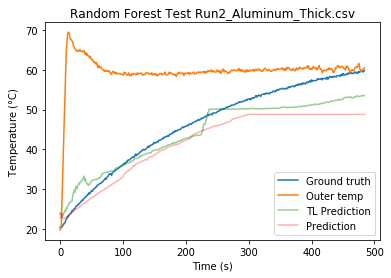

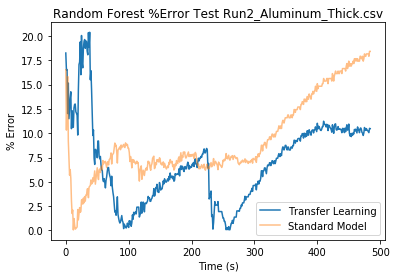

Transfer Learning Score: 0.7188526283719214
Standard Scores: -0.21219508225329475
Transfer Learning RMSE: 4.844408690869378
Standard RMSE: 10.059120706772125


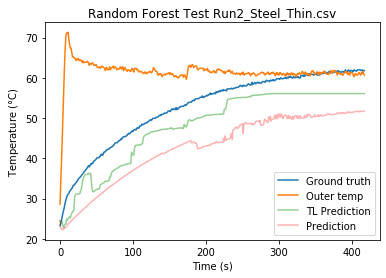

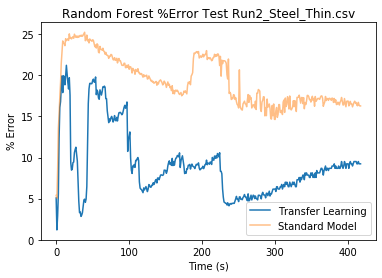

Transfer Learning Score: 0.6879638905047385
Standard Scores: 0.6779604023483339
Transfer Learning RMSE: 5.0241718030955065
Standard RMSE: 5.104070827199658


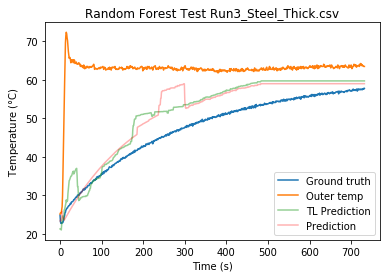

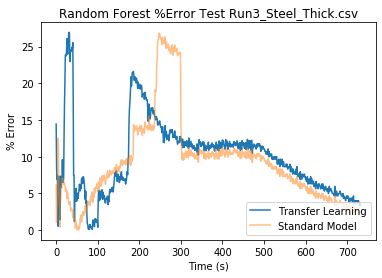

Transfer Learning Score: 0.9250218579855576
Standard Scores: 0.402084125288643
Transfer Learning RMSE: 2.4441788863515477
Standard RMSE: 6.902170658023943


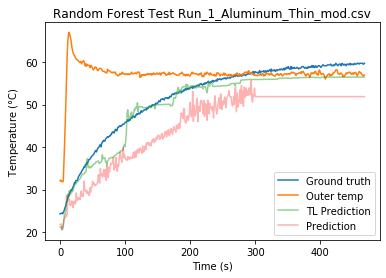

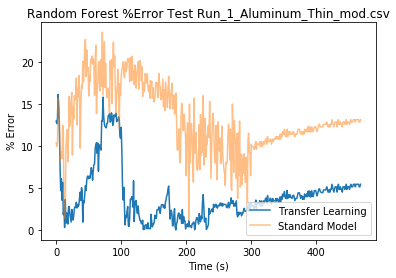

Time:  27.613354800000025


In [13]:
for i in range(0,num_runs):
    trans_r2_score_str = str(trans_r2_score[i])
    r2_score_str = str(r2_score[i])
    print('Transfer Learning Score: ' + trans_r2_score_str)
    print('Standard Scores: ' + r2_score_str)
    trans_rmse_str = str(trans_rmse[i])
    rmse_str = str(rmse[i])
    print('Transfer Learning RMSE: ' + trans_rmse_str)
    print('Standard RMSE: ' + rmse_str)
    plt.figure
    plt.plot(range(len(truth_array[i])), trans_truth_array[i], label="Ground truth")
    plt.plot(range(len(truth_array[i])), trans_cv_features[i][:,4], label="Outer temp")
    plt.plot(range(len(truth_array[i])), trans_prediction_array[i], label="TL Prediction", alpha=0.5)
    plt.plot(range(len(truth_array[i])), prediction_array[i], 'r', label="Prediction", alpha=0.3)
    plt.legend(loc="lower right")
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature ($\degree$C)')
    plt.title('Random Forest Test ' + cv_file_names[i])
    plt.show()
    plt.figure
    plt.plot(range(len(trans_error_array[i])), trans_error_array[i], label="Transfer Learning")
    plt.plot(range(len(error_array[i])), error_array[i], label="Standard Model", alpha=0.5, )
    plt.legend(loc="lower right")
    plt.xlabel('Time (s)')
    plt.ylabel('% Error')
    plt.title('Random Forest %Error Test ' + cv_file_names[i])
    plt.show()

stop = timeit.default_timer()
print('Time: ', stop - start)  

(array([2., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([ 5.10407083,  5.59957582,  6.0950808 ,  6.59058579,  7.08609078,
         7.58159577,  8.07710075,  8.57260574,  9.06811073,  9.56361572,
        10.05912071]),
 <a list of 10 Patch objects>)

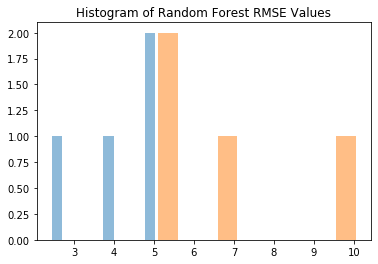

In [15]:
histogram = plt.figure()
ax = histogram.add_subplot(1,1,1)
ax.set_title('Histogram of Random Forest RMSE Values')
ax.hist(trans_rmse, alpha=0.5, label='Transfer Learning')
ax.hist(rmse, alpha=0.5, label='Standard Random Forest')

In [16]:
print(trans_rmse)

[3.770871823560886, 4.844408690869378, 5.0241718030955065, 2.4441788863515477]


In [17]:
print(rmse)

[5.462521908935398, 10.059120706772125, 5.104070827199658, 6.902170658023943]
